In [96]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import decord
import json
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import PIL.Image
from glob import glob
from natsort import natsorted

from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
import numpy as np
import json
import einops

import shared.utils as su
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
)
from models.modeling_encoders import AutoEncoder
from notebooks.eval_care_retrieval import load_model, load_data

In [2]:
from utils.video import read_frames_decord
from models.modeling_encoders import AutoEncoder

device_map = "auto"
attn_implementation = 'eager'


model_path = "/work/piyush/pretrained_checkpoints/TARA"
model = AutoEncoder.from_pretrained(
    model_path,
    device_map=device_map,
    attn_implementation=attn_implementation,
    use_flash_attn=False,
    dtype=torch.bfloat16,
)
su.misc.num_params(model.model)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/pretrained_checkpoints/TARA
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


use_flash_attn is False, even though Flash Attention 2 is available on this GPU.
Using attn_implementation for TarsierForConditionalGeneration: eager


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M


### Load sample data

In [3]:
# Load data

dataset = 'ssv2'
label_col = 'label'

# dataset = 'epic'
# label_col = 'narration'

df = load_data(dataset)
df = df.drop_duplicates(subset=['id', 'text_id']).reset_index(drop=True)

# Chiral IDs
chiral_triplet_ids = df.chiral_triplet_id.unique()

df.shape

Number of rows:  1430
Sample row: 
{
    "id": 69703,
    "label": "moving pen up",
    "template": "Moving [something] up",
    "placeholders": "['pen']",
    "target": 114,
    "chiral_label": 0.0,
    "chiral_triplet_id": "3f20f09b",
    "noun": "['something']",
    "text_id": "3f20f09b_0.0",
    "video_path": "/scratch/shared/beegfs/piyush/datasets/SSv2/20bn-something-something-v2/69703.webm"
}


(1430, 10)

### Attention weights

In [4]:
# i = 0
i = np.random.randint(len(df))
row = df.iloc[i].to_dict()

In [5]:
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
    functional,
)

video_path = row['video_path']
n_frames = 4
video = read_frames_decord(video_path, n_frames)
video.shape

torch.Size([4, 3, 240, 427])

In [6]:
pixel_values = video.unsqueeze(0)
pixel_values = transform_pixel_values(pixel_values) # [B, T, C, H, W]
nframes = pixel_values.shape[1]
prompt = model.image_eol_prompt if nframes == 1 else model.video_eol_prompt

to_image = ToPILImage()
batched_frames = []
for batch in pixel_values:
    frames = [to_image(v) for v in batch]
    batched_frames.append(frames)

generate_kwargs = {
    "max_new_tokens": 1,
    "output_hidden_states": True,
    "return_dict_in_generate": True,
    "output_attentions": True,
}
frames = batched_frames[0]
frames

[<PIL.Image.Image image mode=RGB size=427x240>,
 <PIL.Image.Image image mode=RGB size=427x240>,
 <PIL.Image.Image image mode=RGB size=427x240>,
 <PIL.Image.Image image mode=RGB size=427x240>]

In [7]:
with torch.no_grad():
    input_prompt = prompt.replace("<video>", "<image>"*len(frames))
    input_ids = model.processor.get_text_inputs(input_prompt)
    frames_input = model.processor.get_pixel_values(frames)
    inputs = {
        "input_ids": input_ids,
        "pixel_values": frames_input
    }
    inputs = {k:v.to(model.model.device) for k,v in inputs.items() if v is not None}
    outputs = model.model.generate(
        **inputs,
        **generate_kwargs,
    )

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [9]:
input_prompt

'USER: <image><image><image><image>\nSummary above video in one word: ASSISTANT: '

In [113]:
input_ids

tensor([[    1,  3148,  1001, 29901, 29871, 32000, 32000, 32000, 32000, 29871,
            13, 26289,  2038,  4863,   297,   697,  1734, 29901,   319,  1799,
          9047, 13566, 29901, 29871]])

In [83]:
model.tokenizer.encode("USER: "), \
model.tokenizer.encode("USER: <image><image><image><image>\nSummary above video in one word:")

([1, 3148, 1001, 29901, 29871],
 [1,
  3148,
  1001,
  29901,
  29871,
  32000,
  32000,
  32000,
  32000,
  29871,
  13,
  26289,
  2038,
  4863,
  297,
  697,
  1734,
  29901])

In [22]:
# -, + 3 ... 9
5 + 600 * n_frames, 5 + 600 * n_frames + 3

(2405, 2408)

In [24]:
import torch
import numpy as np
from PIL import Image

def invert_llava_processed_tensor(proc_tensor):
    """
    proc_tensor: torch.Tensor of shape [n, 3, 336, 336], dtype float32
    returns: list of PIL.Image (RGB, uint8) of length n
    """
    assert isinstance(proc_tensor, torch.Tensor)
    assert proc_tensor.dim() == 4 and proc_tensor.size(1) == 3

    # CLIPImageProcessor settings from your config:
    image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], dtype=proc_tensor.dtype, device=proc_tensor.device)
    image_std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], dtype=proc_tensor.dtype, device=proc_tensor.device)
    rescale_factor = 1.0 / 255.0  # 0.00392156862745098

    # Undo normalization: x_rescaled (in [~0,~1]) = proc * std + mean
    x_rescaled = proc_tensor * image_std.view(1,3,1,1) + image_mean.view(1,3,1,1)

    # Convert to [0..255] range
    x_255 = x_rescaled * (1.0 / rescale_factor)  # since rescale_factor = 1/255, dividing by it multiplies by 255
    # Equivalent: x_255 = x_rescaled * 255.0

    # Clip, round, cast
    x_255 = torch.clamp(x_255, 0.0, 255.0)
    x_uint8 = x_255.permute(0,2,3,1).cpu().numpy().astype(np.uint8)  # shape [n, H, W, 3]

    # Convert to PIL Images
    imgs = [Image.fromarray(x_uint8[i]) for i in range(x_uint8.shape[0])]
    return imgs


frames_to_viz = invert_llava_processed_tensor(frames_input)
# su.visualize.concat_images_with_border(frames_to_viz)

In [37]:
n_prefix = len(model.tokenizer.encode('USER: '))
n_prefix

5

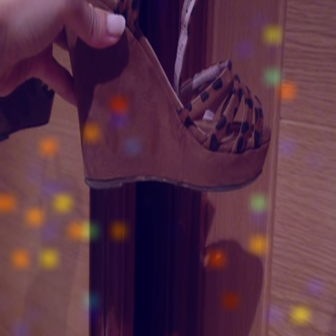

In [95]:
query_index = 5 + 601 * n_frames + 9
# key_indices = np.arange(5 + 1, 5 + 600 + 1)
key_indices = np.arange(5 + 600 + 2, 5 + 600*2 + 1*2)
len(key_indices)

layer = 3
# head = 1
o = outputs['attentions'][0][layer][0].mean(dim=0)[query_index, key_indices].cpu().float()
# o = outputs['attentions'][0][layer][0][head][query_index, key_indices].cpu().float()
o = einops.rearrange(o, "(h w) -> h w", h=24, w=25)[:, :-1]
su.visualize.blend_images(
    frames_to_viz[1],
    su.visualize.tensor_to_heatmap(o, cmap='jet').resize((336, 336)),
    alpha=0.3
)

In [97]:
len(outputs['attentions'][0]), outputs['attentions'][0][0].shape

(32, torch.Size([1, 32, 2424, 2424]))

In [104]:
from notebooks.vlm_viz_utils import heterogenous_stack, aggregate_llm_attention

# constructing the llm attention matrix
aggregated_prompt_attention = []
for i, layer in enumerate(outputs["attentions"][0]):
    layer_attns = layer.squeeze(0)
    attns_per_head = layer_attns.mean(dim=0)
    cur = attns_per_head[:-1].cpu().clone()
    # following the practice in `aggregate_llm_attention`
    # we are zeroing out the attention to the first <bos> token
    # for the first row `cur[0]` (corresponding to the next token after <bos>), however,
    # we don't do this because <bos> is the only token that it can attend to
    cur[1:, 0] = 0.
    cur[1:] = cur[1:] / cur[1:].sum(-1, keepdim=True)
    aggregated_prompt_attention.append(cur)
aggregated_prompt_attention = torch.stack(aggregated_prompt_attention).mean(dim=0)

# llm_attn_matrix will be of torch.Size([N, N])
# where N is the total number of input (both image and text ones) + output tokens
llm_attn_matrix = heterogenous_stack(
    [torch.tensor([1])]
    + list(aggregated_prompt_attention) 
    + list(map(aggregate_llm_attention, outputs["attentions"]))
)
llm_attn_matrix.shape

torch.Size([2425, 2425])

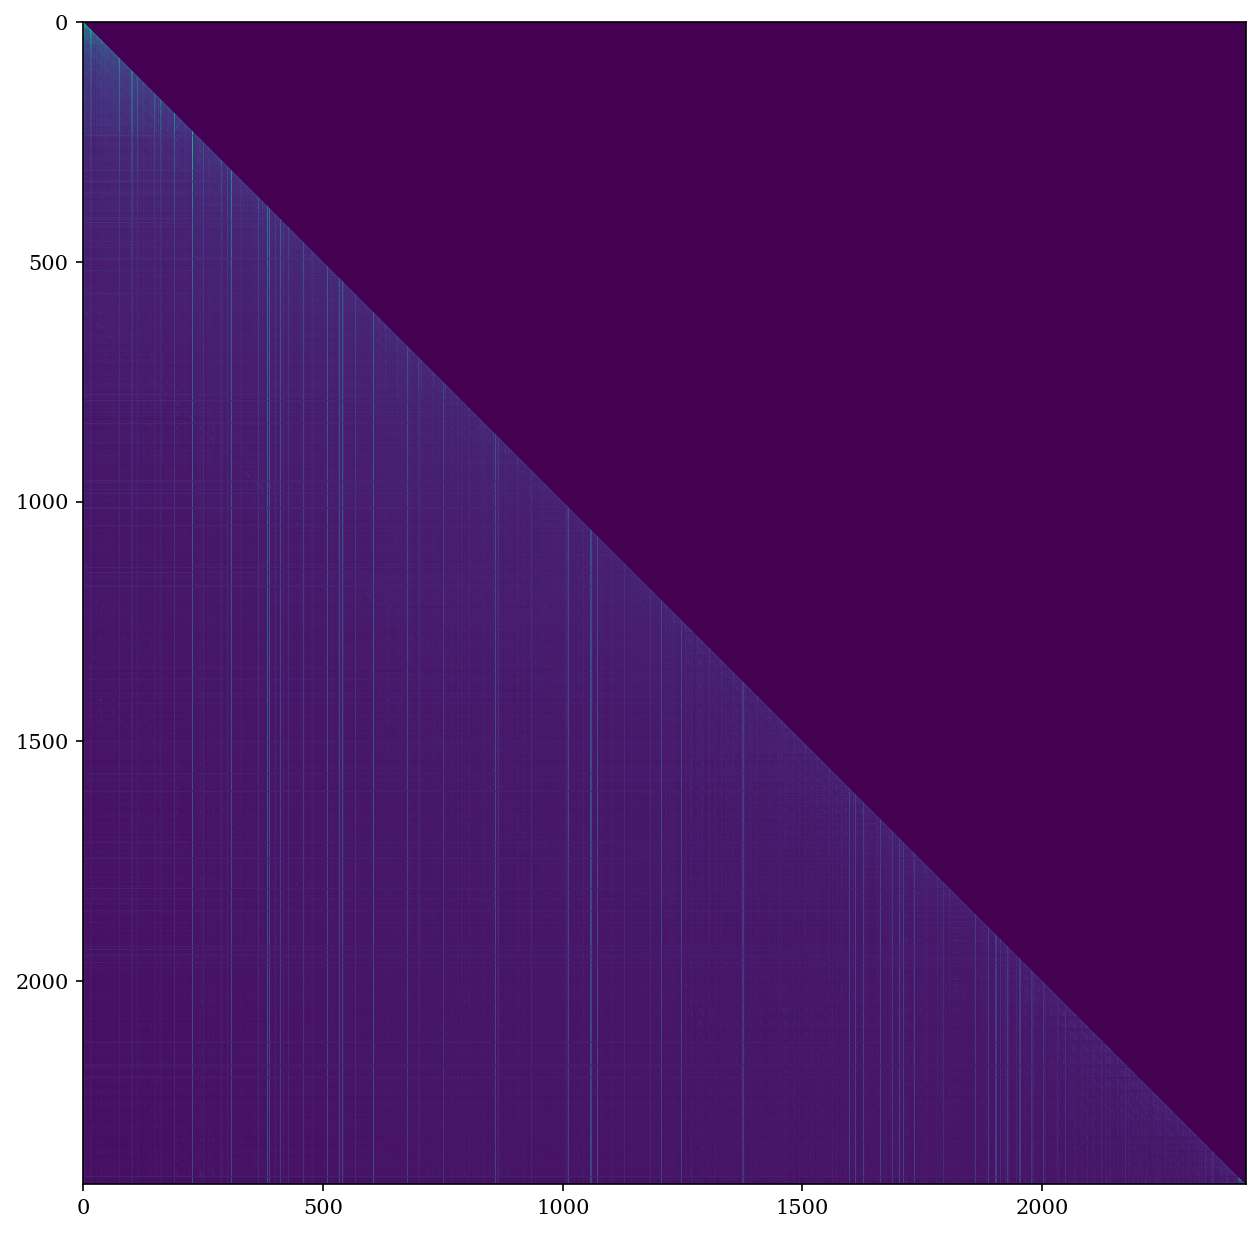

In [109]:
# visualize the llm attention matrix
# ===> adjust the gamma factor to enhance the visualization
#      higer gamma brings out more low attention values
gamma_factor = 3.
enhanced_attn_m = np.power(llm_attn_matrix.numpy(), 1 / gamma_factor)

fig, ax = plt.subplots(figsize=(10, 20), dpi=150)
ax.imshow(enhanced_attn_m, vmin=enhanced_attn_m.min(), vmax=enhanced_attn_m.max(), interpolation="nearest")

In [110]:
llm_attn_matrix.shape

torch.Size([2425, 2425])

In [114]:
vision_token_start = 5
vision_token_end = 5 + 601 * n_frames

output_token_start = vision_token_end + 1
output_token_end = output_token_start + 15

vision_token_start, vision_token_end, output_token_start, output_token_end

(5, 2409, 2410, 2425)

In [116]:
input_token_len = 2424

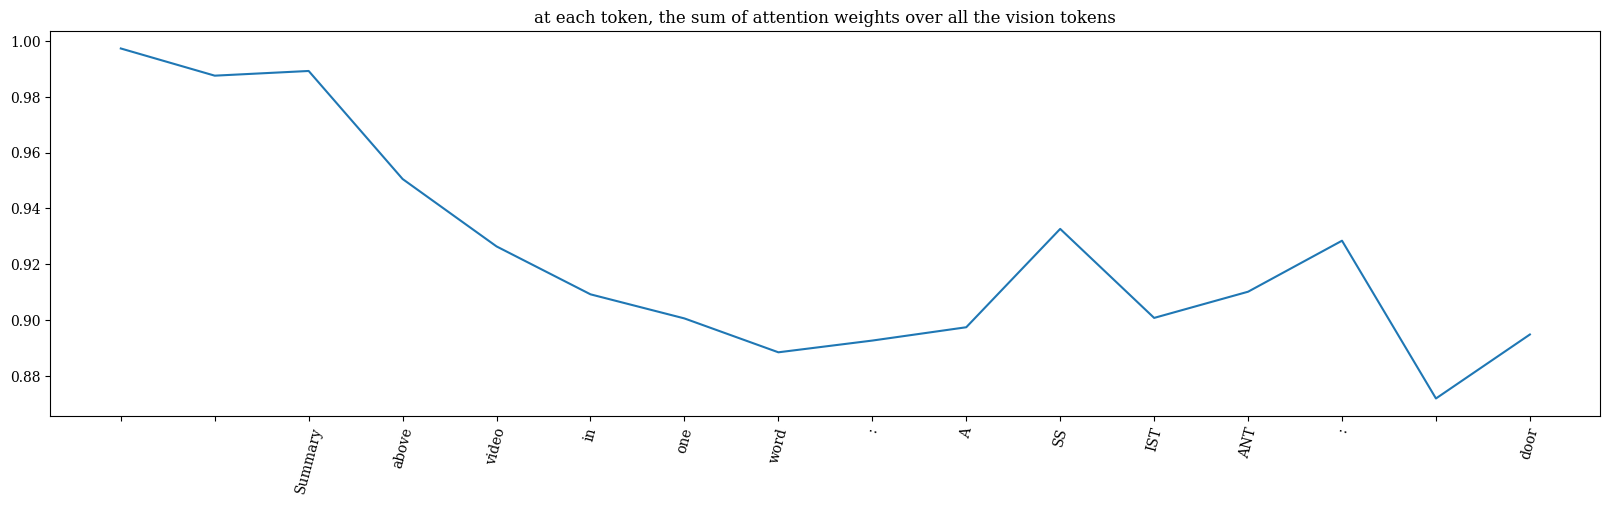

In [125]:
# look at the attention weights over the vision tokens
overall_attn_weights_over_vis_tokens = []
for i, (row, token) in enumerate(
    zip(
        llm_attn_matrix[2409:], 
        outputs["sequences"][0].tolist()
    )
):
    # print(
    #     i + input_token_len, 
    #     f"{tokenizer.decode(token, add_special_tokens=False).strip():<15}", 
    #     f"{row[vision_token_start:vision_token_end].sum().item():.4f}"
    # )

    overall_attn_weights_over_vis_tokens.append(
        row[vision_token_start:vision_token_end].sum().item()
    )

# plot the trend of attention weights over the vision tokens
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(overall_attn_weights_over_vis_tokens)
ax.set_xticks(range(len(overall_attn_weights_over_vis_tokens)))
ax.set_xticklabels(
    [
        model.tokenizer.decode(
            token, add_special_tokens=False
        ).strip() for token in outputs["sequences"][0][5+4:].tolist()
    ],
    rotation=75
)
ax.set_title("at each token, the sum of attention weights over all the vision tokens");

In [179]:
target_token_ind = 2410
attn_weights_over_vis_tokens = llm_attn_matrix[target_token_ind][vision_token_start:vision_token_end]
attn_weights_over_vis_tokens = attn_weights_over_vis_tokens[torch.tensor(list(set(np.arange(2404)) - {601, 1202, 1803, 2403}), dtype=int)]
attn_weights_over_vis_tokens = attn_weights_over_vis_tokens / attn_weights_over_vis_tokens.sum()
# attn_weights_over_vis_tokens = torch.clip(attn_weights_over_vis_tokens, 0, 0.0005)
attn_weights_over_vis_tokens[attn_weights_over_vis_tokens > 0.001] = 0.
o = einops.rearrange(attn_weights_over_vis_tokens, "(t h w) -> t h w", t=4, h=24, w=25)[:, :, :-1]

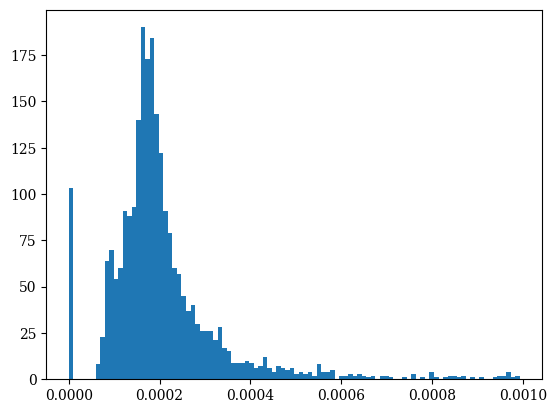

In [180]:
# attn_weights_over_vis_tokens = llm_attn_matrix[target_token_ind][vision_token_start:vision_token_end]
plt.hist(attn_weights_over_vis_tokens, bins=100);

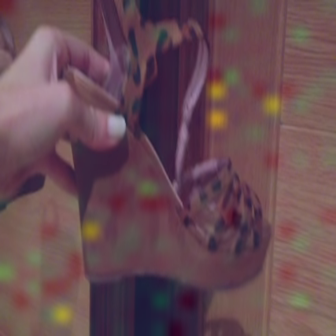

In [181]:
su.visualize.blend_images(frames_to_viz[2], su.visualize.tensor_to_heatmap(o[2]).resize((336, 336)), 0.4)

torch.Size([2400])

In [ ]:
# connect with the vision encoder attention
# to visualize the attention over the image

# vis_attn_matrix will be of torch.Size([N, N])
# where N is the number of vision tokens/patches
# `all_prev_layers=True` will average attention from all layers until the selected layer
# otherwise only the selected layer's attention will be used
vis_attn_matrix = aggregate_vit_attention(
    model.get_vision_tower().image_attentions,
    select_layer=model.get_vision_tower().select_layer,
    all_prev_layers=True
)
grid_size = model.get_vision_tower().num_patches_per_side

num_image_per_row = 8
image_ratio = image_size[0] / image_size[1]
num_rows = output_token_len // num_image_per_row + (1 if output_token_len % num_image_per_row != 0 else 0)
fig, axes = plt.subplots(
    num_rows, num_image_per_row, 
    figsize=(10, (10 / num_image_per_row) * image_ratio * num_rows), 
    dpi=150
)
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# whether visualize the attention heatmap or 
# the image with the attention heatmap overlayed
vis_overlayed_with_attn = True

output_token_inds = list(range(output_token_start, output_token_end))
for i, ax in enumerate(axes.flatten()):
    if i >= output_token_len:
        ax.axis("off")
        continue

    target_token_ind = output_token_inds[i]
    attn_weights_over_vis_tokens = llm_attn_matrix[target_token_ind][vision_token_start:vision_token_end]
    attn_weights_over_vis_tokens = attn_weights_over_vis_tokens / attn_weights_over_vis_tokens.sum()

    attn_over_image = []
    for weight, vis_attn in zip(attn_weights_over_vis_tokens, vis_attn_matrix):
        vis_attn = vis_attn.reshape(grid_size, grid_size)
        # vis_attn = vis_attn / vis_attn.max()
        attn_over_image.append(vis_attn * weight)
    attn_over_image = torch.stack(attn_over_image).sum(dim=0)
    attn_over_image = attn_over_image / attn_over_image.max()

    attn_over_image = F.interpolate(
        attn_over_image.unsqueeze(0).unsqueeze(0), 
        size=image.size, 
        mode='nearest', 
        # mode='bicubic', align_corners=False
    ).squeeze()

    np_img = np.array(image)[:, :, ::-1]
    img_with_attn, heatmap = show_mask_on_image(np_img, attn_over_image.numpy())
    ax.imshow(heatmap if not vis_overlayed_with_attn else img_with_attn)
    ax.set_title(
        tokenizer.decode(outputs["sequences"][0][i], add_special_tokens=False).strip(),
        fontsize=7,
        pad=1
    )
    ax.axis("off");

In [124]:
outputs["sequences"][0][5+4:]

torch.Size([16])

In [120]:
overall_attn_weights_over_vis_tokens

[0.8948995471000671]

In [39]:
# Single image
# [x] [x] ... [x] [\n]
# [x] [x] ... [x] [\n]
# .
# .
# [x] [x] ... [x] [\n]

# Between images as well, there is a [\n] token that needs ignoring

key_index = 5 + 600 * n_frames + 3

n_tokens_per_frame = (24 + 1) * 24
layer = 0
# head = 0
heatmaps = []
for j in range(n_frames):
    start = (n_prefix + 1) + n_tokens_per_frame * j + 1 * j
    end = start + n_tokens_per_frame
    print(j, start, end)

    # w = outputs['attentions'][0][layer][0][head]
    w = outputs['attentions'][0][layer][0].mean(dim=0)

    # From last token to the j'th image
    w = w[key_index, start:end]

    # Reshape and ignore the newline tokens within each image
    # w = einops.rearrange(w, "(h w) -> h w", w=24, h=25)[:, :-1].T
    w = einops.rearrange(w, "(w h) -> w h", w=25, h=24)[:-1, :]
    heatmaps.append(w)
    print(w.shape)
    # print(w)
heatmaps = torch.stack(heatmaps)
heatmaps = torch.nn.functional.interpolate(
    heatmaps.unsqueeze(1), size=tuple(frames_input.shape[-2:])
).squeeze(1).cpu().float()

heatmaps.shape

0 6 606
torch.Size([24, 24])
1 607 1207
torch.Size([24, 24])
2 1208 1808
torch.Size([24, 24])
3 1809 2409
torch.Size([24, 24])


torch.Size([4, 336, 336])

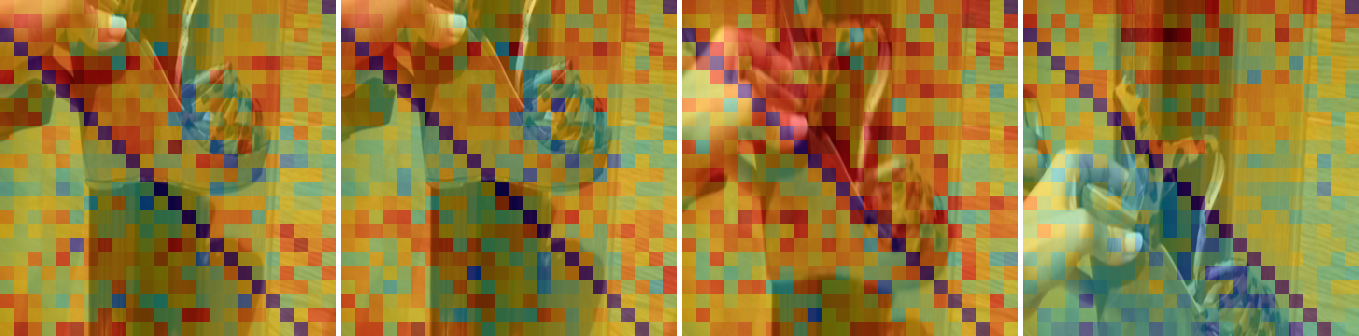

In [41]:
heatmaps_to_viz = su.visualize.batch_tensor_to_heatmap(heatmaps, cmap='jet')
# su.visualize.concat_images_with_border(heatmaps_to_viz)

blend_images = [
    su.visualize.blend_images(x, y, 0.4) for x, y in zip(frames_to_viz, heatmaps_to_viz)
]
su.visualize.concat_images_with_border(blend_images)

In [19]:
outputs.keys()

odict_keys(['sequences', 'hidden_states'])

### Token distributions

In [8]:
def extract_topk_tokens(model, frames_raw, k=25):
    with torch.no_grad():
        zv = model.encode_vision(frames_raw.unsqueeze(0))
        logits = model.model.language_model.lm_head(zv).cpu().float().squeeze(0)

    # Pick up top-K tokens to look at and their logit values
    topk = torch.topk(logits, k=k, dim=-1)
    topk_values = topk.values
    topk_indices = topk.indices

    # Decode into strings
    token_strings = [model.processor.tokenizer.decode([t], skip_special_tokens=False) for t in topk_indices]

    return token_strings, topk_values

In [15]:
def plot_logits(token_strings, values, ax, cmap=None, label_fontsize=10):
    """
    Plot vertical bars for token logits, place token labels inside bars,
    and color bars according to logit magnitude (darker = larger).
    
    Args:
        token_strings: list of str, labels for each bar (same order as values)
        values: array-like or torch.Tensor of shape (K,)
        ax: matplotlib Axes to draw on
        cmap: matplotlib colormap (optional). Defaults to plt.cm.Blues.
        label_fontsize: int font size for labels placed inside bars
    Returns:
        bars: BarContainer from ax.bar
    """
    import numpy as np
    import matplotlib.pyplot as plt

    if cmap is None:
        cmap = plt.cm.Blues

    # --- Normalize values, accepting torch.Tensor or numpy/list ---
    try:
        # if torch is available and it's a tensor, convert safely
        import torch
        if isinstance(values, torch.Tensor):
            vals = values.detach().cpu().numpy()
        else:
            vals = np.asarray(values)
    except Exception:
        vals = np.asarray(values)

    vals = np.array(vals, dtype=float).ravel()
    if vals.size != len(token_strings):
        raise ValueError("length of token_strings must match length of values")

    # --- Color mapping (higher -> darker) ---
    vmin = float(vals.min())
    vmax = float(vals.max())
    denom = (vmax - vmin) if (vmax != vmin) else 1.0
    norm = (vals - vmin) / denom  # in [0,1]
    # map norm to colormap range (avoid the very pale end)
    color_values = [cmap(0.25 + 0.75 * n) for n in norm]

    # --- Draw bars ---
    x = np.arange(len(token_strings))
    bars = ax.bar(x, vals, color=color_values, edgecolor='none')

    # axes labels + grid
    ax.set_xlabel("Token")
    ax.set_ylabel("Logit Value")
    ax.grid(axis="y", alpha=0.4)

    # remove crowded x-ticks; we'll draw labels inside bars instead
    ax.set_xticks([])

    # --- Put token labels inside each bar ---
    for i, (bar, tok, n) in enumerate(zip(bars, token_strings, norm)):
        height = bar.get_height()
        # Choose readable text color depending on darkness (norm)
        text_color = "white" if n > 0.55 else "black"
        # place text centered horizontally, at ~50% of the bar height
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            max(0.02 * (vmax - vmin), height * 0.5),  # small floor so very small bars still show label
            tok,
            ha="center",
            va="center",
            rotation=90,            # rotate to match your example
            fontsize=label_fontsize,
            color=text_color,
            clip_on=True,
        )

    # tighten layout so labels aren't clipped
    ax.figure.tight_layout()
    return bars


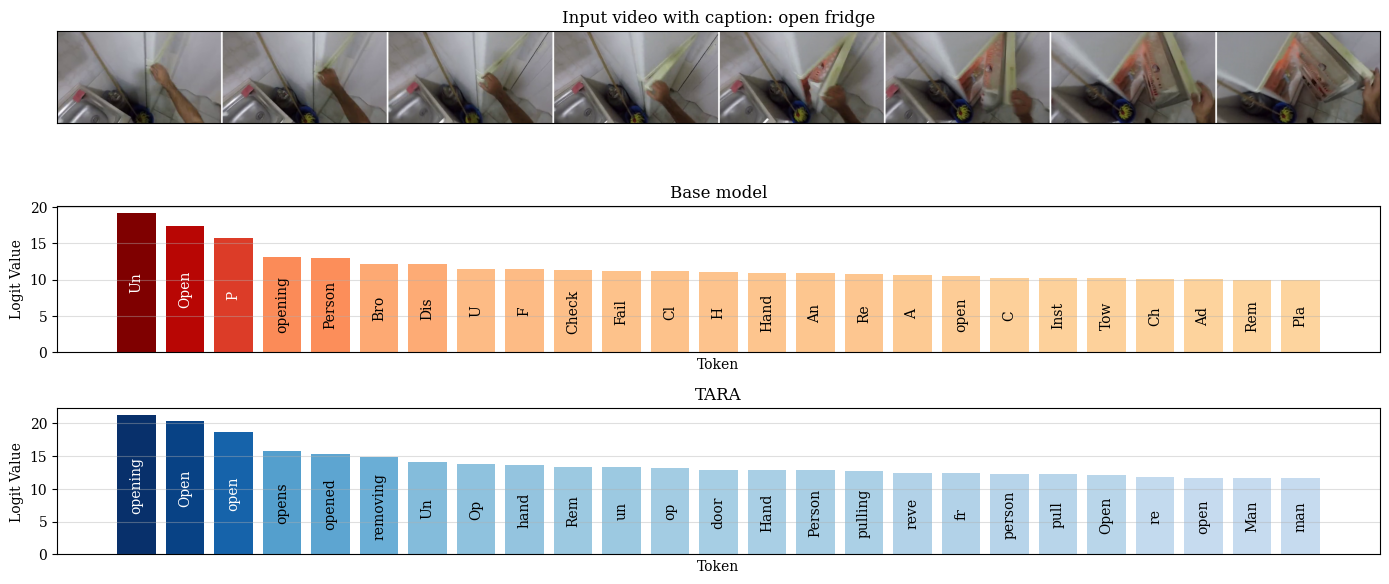

In [39]:
i = np.random.randint(len(df))
row = df.iloc[i].to_dict()
row

video_path = row['video_path']
frames_raw = read_frames_decord(video_path, 8)
tokens_base, logits_base = extract_topk_tokens(model_base, frames_raw)
tokens_fine, logits_fine = extract_topk_tokens(model_fine, frames_raw)

fig, axes = plt.subplots(3, 1, figsize=(14, 6))
canvas = su.visualize.concat_images_with_border(
    [PIL.Image.fromarray(f.numpy()) for f in frames_raw.permute((0, 2, 3, 1))]
)
ax = axes[0]
ax.imshow(canvas)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title("Input video with caption: %s" % row[label_col])

ax = axes[1]
plot_logits(tokens_base, logits_base, ax, cmap=plt.cm.OrRd)
ax.set_title("Base model")

ax = axes[2]
plot_logits(tokens_fine, logits_fine, ax, cmap=plt.cm.Blues)
ax.set_title("TARA")

plt.tight_layout()
plt.show()